In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the customer and transaction data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [3]:
customers_df.info()
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [29]:
transaction_data = transactions_df.groupby('CustomerID').agg(
    Total_Spend=('TotalValue', 'sum'),
    Num_Transactions=('TransactionID', 'count'),
    Avg_Price=('Price', 'mean')
).reset_index()
print(transaction_data)

    CustomerID  Total_Spend  Num_Transactions   Avg_Price
0        C0001      3354.52                 5  278.334000
1        C0002      1862.74                 4  208.920000
2        C0003      2725.38                 4  195.707500
3        C0004      5354.88                 8  240.636250
4        C0005      2034.24                 3  291.603333
..         ...          ...               ...         ...
194      C0196      4982.88                 4  416.992500
195      C0197      1928.65                 3  227.056667
196      C0198       931.83                 2  239.705000
197      C0199      1979.28                 4  250.610000
198      C0200      4758.60                 5  296.506000

[199 rows x 4 columns]


In [28]:
merged_df = pd.merge(customers_df, transaction_data, on='CustomerID', how='inner')
print(merged_df)

    CustomerID        CustomerName         Region  SignupDate  Total_Spend  \
0        C0001    Lawrence Carroll  South America  2022-07-10      3354.52   
1        C0002      Elizabeth Lutz           Asia  2022-02-13      1862.74   
2        C0003      Michael Rivera  South America  2024-03-07      2725.38   
3        C0004  Kathleen Rodriguez  South America  2022-10-09      5354.88   
4        C0005         Laura Weber           Asia  2022-08-15      2034.24   
..         ...                 ...            ...         ...          ...   
194      C0196         Laura Watts         Europe  2022-06-07      4982.88   
195      C0197    Christina Harvey         Europe  2023-03-21      1928.65   
196      C0198         Rebecca Ray         Europe  2022-02-27       931.83   
197      C0199      Andrea Jenkins         Europe  2022-12-03      1979.28   
198      C0200         Kelly Cross           Asia  2023-06-11      4758.60   

     Num_Transactions   Avg_Price  
0                   5  278.

In [27]:
cluster_data = merged_df[['Total_Spend', 'Num_Transactions', 'Avg_Price']]
print(cluster_data)

     Total_Spend  Num_Transactions   Avg_Price
0        3354.52                 5  278.334000
1        1862.74                 4  208.920000
2        2725.38                 4  195.707500
3        5354.88                 8  240.636250
4        2034.24                 3  291.603333
..           ...               ...         ...
194      4982.88                 4  416.992500
195      1928.65                 3  227.056667
196       931.83                 2  239.705000
197      1979.28                 4  250.610000
198      4758.60                 5  296.506000

[199 rows x 3 columns]


In [18]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

In [19]:
num_clusters = 4  # Modify this based on your analysis
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

KMeans(n_clusters=4, random_state=42)

In [26]:
merged_df['Cluster'] = kmeans.labels_
print(merged_df['Cluster'] )

0      3
1      2
2      2
3      1
4      0
      ..
194    0
195    2
196    2
197    2
198    3
Name: Cluster, Length: 199, dtype: int32


In [21]:
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f"DB Index: {db_index}")


DB Index: 1.0031741006145798


In [25]:
# Visualize the clusters using PCA for dimensionality reduction (2D visualization)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
merged_df['PCA1'] = principal_components[:, 0]
merged_df['PCA2'] = principal_components[:, 1]
print(merged_df['PCA1'])
print(merged_df['PCA2'])


0     -0.020679
1     -1.201030
2     -0.929568
3      1.447995
4     -1.048744
         ...   
194    0.946836
195   -1.383490
196   -1.999566
197   -0.966235
198    0.601982
Name: PCA1, Length: 199, dtype: float64
0      0.091606
1     -0.599798
2     -0.780487
3     -1.005168
4      0.668463
         ...   
194    2.072298
195   -0.169406
196    0.200682
197   -0.059130
198    0.313226
Name: PCA2, Length: 199, dtype: float64


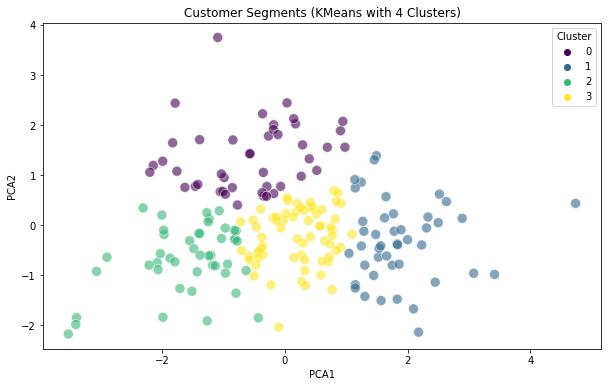

In [23]:
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=merged_df, palette='viridis', s=100, alpha=0.6)
plt.title(f'Customer Segments (KMeans with {num_clusters} Clusters)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', loc='best')
plt.show()